Cellule 1 — Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add src to path
sys.path.append('..')

from src.models.train import (
    MLflowTracker,
    BaselineTrainer,
    FineTuner,
    EnsembleBuilder,
    ModelSelector,
    load_data
)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful")


✅ Imports successful


Cellule 2 — Charger les données

In [2]:
# Load datasets
X_train, y_train, X_val, y_val, X_test, y_test = load_data('../data/processed/v1')

print(f"📊 Dataset Shapes:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Test:  {X_test.shape}")

print(f"\n🎯 Target Statistics:")
print(f"   Train: {y_train.mean():.2f} ± {y_train.std():.2f}")
print(f"   Val:   {y_val.mean():.2f} ± {y_val.std():.2f}")
print(f"   Test:  {y_test.mean():.2f} ± {y_test.std():.2f}")


📊 Dataset Shapes:
   Train: (3480, 38)
   Val:   (580, 38)
   Test:  (580, 38)

🎯 Target Statistics:
   Train: 52.53 ± 17.99
   Val:   52.60 ± 18.87
   Test:  52.65 ± 17.74


Cellule 3 — Initialiser MLflow

In [3]:
# Initialize MLflow tracker
tracker = MLflowTracker('../configs/mlflow_config.yaml')

print("\n💡 TIP: To view MLflow UI, run in terminal:")
print("   mlflow ui --port 5000")
print("   Then open: http://localhost:5000")


2025/12/11 15:34:22 INFO mlflow.tracking.fluent: Experiment with name 'premier-league-prediction' does not exist. Creating a new experiment.
2025/12/11 15:34:22 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 1.4.0 <= scikit-learn, but the installed version is 1.3.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


✅ MLflow configured:
   Tracking URI: mlruns
   Experiment: premier-league-prediction

💡 TIP: To view MLflow UI, run in terminal:
   mlflow ui --port 5000
   Then open: http://localhost:5000


Cellule 4 — Baseline models

In [4]:
# Create baseline trainer
baseline_trainer = BaselineTrainer(tracker)

# Train all baseline models
baseline_models, baseline_results = baseline_trainer.train_all_baselines(
    X_train, y_train, X_val, y_val
)



PHASE 1: BASELINE MODELS

🔄 Training ridge...


2025/12/11 15:34:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Val MAE: 4.85, Val R²: 0.8819
🔄 Training lasso...


2025/12/11 15:35:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Val MAE: 4.74, Val R²: 0.8788
🔄 Training elastic_net...


2025/12/11 15:35:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Val MAE: 4.63, Val R²: 0.8866
🔄 Training random_forest...


2025/12/11 15:35:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Val MAE: 5.39, Val R²: 0.8469
🔄 Training gradient_boosting...


2025/12/11 15:35:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Val MAE: 5.24, Val R²: 0.8579
🔄 Training xgboost...


2025/12/11 15:35:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Val MAE: 5.92, Val R²: 0.8217
🔄 Training lightgbm...


2025/12/11 15:35:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Val MAE: 5.22, Val R²: 0.8418

BASELINE RESULTS SUMMARY

Model                Val MAE      Val RMSE     Val R²    
----------------------------------------------------------------------
elastic_net          4.63         6.35         0.8866    
lasso                4.74         6.56         0.8788    
ridge                4.85         6.48         0.8819    
lightgbm             5.22         7.50         0.8418    
gradient_boosting    5.24         7.11         0.8579    
random_forest        5.39         7.38         0.8469    
xgboost              5.92         7.96         0.8217    

🏆 Best baseline model: elastic_net


Cellule 5 — Visualisation baseline

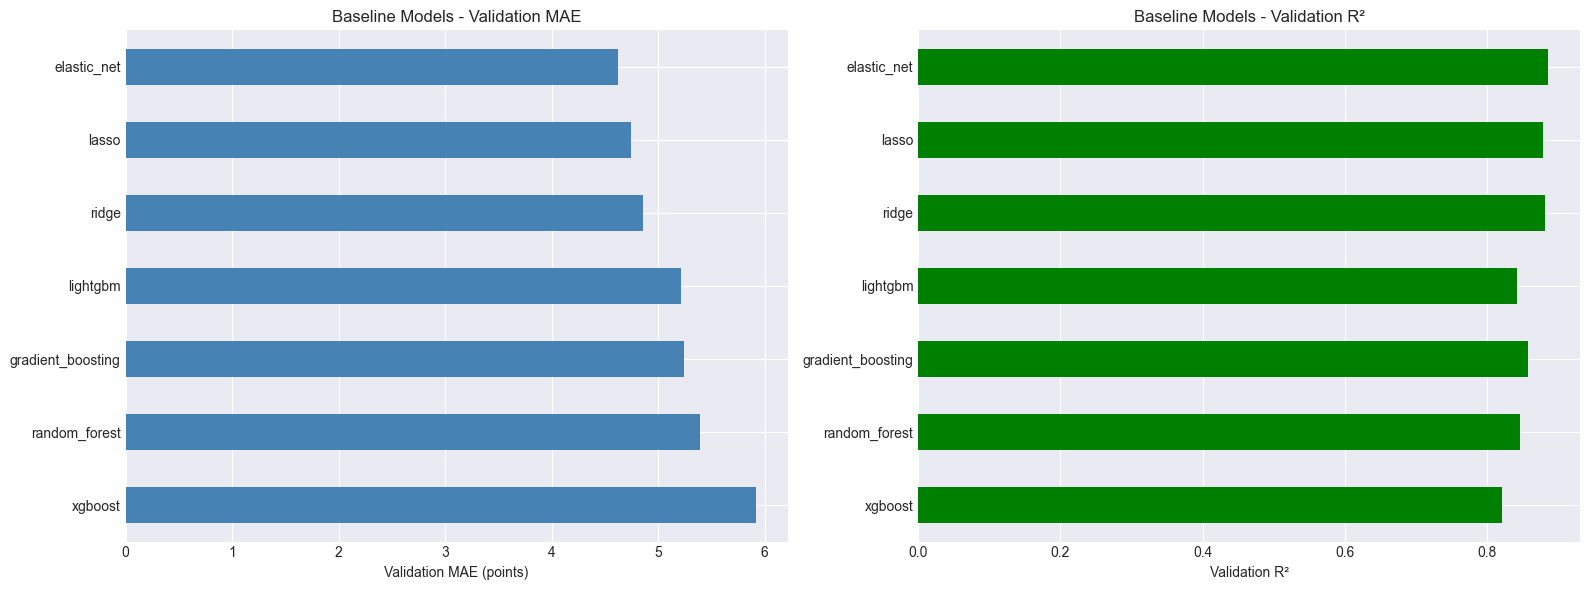


📊 Baseline Results:
                    val_mae  val_rmse    val_r2
elastic_net        4.626694  6.349272  0.886614
lasso              4.742178  6.564280  0.878805
ridge              4.854452  6.479785  0.881905
lightgbm           5.219394  7.499851  0.841796
gradient_boosting  5.239071  7.106692  0.857948
random_forest      5.394379  7.378661  0.846868
xgboost            5.919383  7.962856  0.821660


In [5]:
# Create comparison DataFrame
baseline_df = pd.DataFrame(baseline_results).T

# Sort by val_mae
baseline_df = baseline_df.sort_values('val_mae')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Val MAE
baseline_df['val_mae'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Validation MAE (points)')
axes[0].set_title('Baseline Models - Validation MAE')
axes[0].invert_yaxis()

# Val R²
baseline_df['val_r2'].plot(kind='barh', ax=axes[1], color='green')
axes[1].set_xlabel('Validation R²')
axes[1].set_title('Baseline Models - Validation R²')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n📊 Baseline Results:")
print(baseline_df[['val_mae', 'val_rmse', 'val_r2']])


Cellule 6 — Fine-tuning

In [24]:
# 🔹 Hyperparameters for fine-tuning
hyperparams = {
    'elastic_net': {'alpha': [0.1, 0.5, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]},
    'lasso': {'alpha': [0.01, 0.1, 1.0]},
    'ridge': {'alpha': [0.01, 0.1, 1.0]}
}

# 🔹 Create fine-tuner
finetuner = FineTuner(tracker)

# 🔹 Check what's currently defined
current_params = finetuner.get_param_distributions()
print("Current hyperparameters:", list(current_params.keys()))

# 🔹 Update the existing hyperparameters with your custom ones
current_params.update(hyperparams)

# 🔹 Override the method to return your combined hyperparameters
finetuner.get_param_distributions = lambda: current_params

# 🔹 Fine-tune top 3 models
finetuned_results = finetuner.fine_tune_top_models(
    baseline_results, 
    baseline_models,
    X_train, y_train, 
    X_val, y_val,
    top_n=3
)

Current hyperparameters: ['random_forest', 'xgboost', 'lightgbm', 'gradient_boosting']

PHASE 2: FINE-TUNING TOP MODELS

📊 Fine-tuning top 3 models: ['elastic_net', 'lasso', 'ridge']


🔧 Fine-tuning elastic_net...


2025/12/11 15:48:45 INFO mlflow.sklearn.utils: Logging the 5 best runs, 4 runs will be omitted.
2025/12/11 15:48:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Best Val MAE: 4.63
   ✓ Best params: {'l1_ratio': 0.5, 'alpha': 1.0}

🔧 Fine-tuning lasso...


2025/12/11 15:49:00 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2025/12/11 15:49:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Best Val MAE: 4.74
   ✓ Best params: {'alpha': 1.0}

🔧 Fine-tuning ridge...


2025/12/11 15:49:14 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2025/12/11 15:49:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Best Val MAE: 4.85
   ✓ Best params: {'alpha': 1.0}


Cellule 7 — Comparaison baseline vs fine-tuned

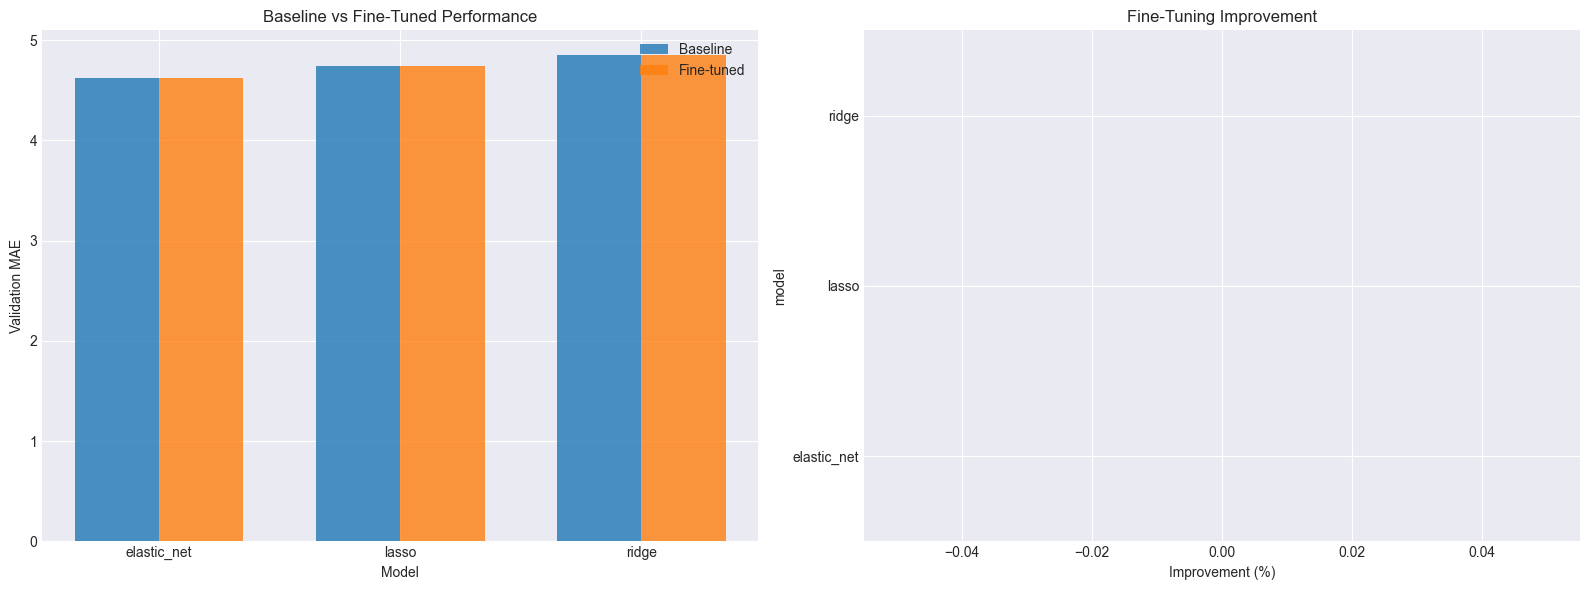


📊 Fine-Tuning Results:
         model  baseline_mae  finetuned_mae  improvement  improvement_pct
0  elastic_net      4.626694       4.626694          0.0              0.0
1        lasso      4.742178       4.742178          0.0              0.0
2        ridge      4.854452       4.854452          0.0              0.0


In [25]:
# Compare baseline vs fine-tuned
comparison = []

for model_name, (model, metrics) in finetuned_results.items():
    baseline_mae = baseline_results[model_name]['val_mae']
    finetuned_mae = metrics['val_mae']
    improvement = baseline_mae - finetuned_mae
    improvement_pct = (improvement / baseline_mae) * 100
    
    comparison.append({
        'model': model_name,
        'baseline_mae': baseline_mae,
        'finetuned_mae': finetuned_mae,
        'improvement': improvement,
        'improvement_pct': improvement_pct
    })

comparison_df = pd.DataFrame(comparison)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['baseline_mae'], width, label='Baseline', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['finetuned_mae'], width, label='Fine-tuned', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Validation MAE')
axes[0].set_title('Baseline vs Fine-Tuned Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['model'])
axes[0].legend()

# Improvement
comparison_df.plot(x='model', y='improvement_pct', kind='barh', ax=axes[1], legend=False, color='green')
axes[1].set_xlabel('Improvement (%)')
axes[1].set_title('Fine-Tuning Improvement')

plt.tight_layout()
plt.show()

print("\n📊 Fine-Tuning Results:")
print(comparison_df)


Cellule 8 — Ensembles

In [26]:
# Get top 3 models for ensemble
all_models = {**baseline_models, **finetuner.best_models}
all_results = {**baseline_results}
for name, (model, metrics) in finetuned_results.items():
    all_results[f"{name}_finetuned"] = metrics

# Sort and select top 3
top_3_models = dict(sorted(
    all_models.items(),
    key=lambda x: all_results.get(x[0], all_results.get(f"{x[0]}_finetuned", {'val_mae': float('inf')}))['val_mae']
)[:3])

print(f"🎯 Using top 3 models for ensemble: {list(top_3_models.keys())}")

# Build ensembles
ensemble_builder = EnsembleBuilder(tracker)
ensemble_results = ensemble_builder.build_ensembles(
    top_3_models, X_train, y_train, X_val, y_val
)


🎯 Using top 3 models for ensemble: ['elastic_net', 'lasso', 'ridge']

PHASE 3: ENSEMBLE METHODS


🎯 Creating Stacking Ensemble...


2025/12/11 15:49:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Stacking Val MAE: 4.58

🎯 Creating Voting Ensemble...


2025/12/11 15:49:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ Voting Val MAE: 4.64


Cellule 9 — Sélection du meilleur modèle

In [28]:
# Combine all results
final_results = {
    'baseline': baseline_results,
    'finetuned': {k: v[1] for k, v in finetuned_results.items()},
    'ensemble': ensemble_results
}

# Select best model
selector = ModelSelector(tracker)
best_model_key, best_metrics = selector.select_best_model(
    final_results, all_models
)



FINAL MODEL SELECTION

Model                          Val MAE      Val RMSE     Val R²    
----------------------------------------------------------------------
ensemble_stacking              4.58         6.45         0.8830    
baseline_elastic_net           4.63         6.35         0.8866    
finetuned_elastic_net          4.63         6.35         0.8866    
ensemble_voting                4.64         6.37         0.8857    
baseline_lasso                 4.74         6.56         0.8788    
finetuned_lasso                4.74         6.56         0.8788    
baseline_ridge                 4.85         6.48         0.8819    
finetuned_ridge                4.85         6.48         0.8819    
baseline_lightgbm              5.22         7.50         0.8418    
baseline_gradient_boosting     5.24         7.11         0.8579    

🏆 BEST MODEL: ensemble_stacking
   Val MAE:  4.58 points
   Val RMSE: 6.45 points
   Val R²:   0.8830


Cellule 10 — Évaluation finale

In [29]:
# Get best model
phase, model_name = best_model_key.rsplit('_', 1)
best_model = ensemble_builder.ensemble_models.get(model_name) or \
             finetuner.best_models.get(model_name) or \
             baseline_models.get(model_name)

# Predict on test set
y_test_pred = best_model.predict(X_test)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "="*70)
print("🏆 FINAL TEST SET EVALUATION")
print("="*70)
print(f"\nBest Model: {best_model_key}")
print(f"\nTest Metrics:")
print(f"  MAE:  {test_mae:.2f} points")
print(f"  RMSE: {test_rmse:.2f} points")
print(f"  R²:   {test_r2:.4f}")
print("="*70)



🏆 FINAL TEST SET EVALUATION

Best Model: ensemble_stacking

Test Metrics:
  MAE:  5.19 points
  RMSE: 6.79 points
  R²:   0.8534


Cellule 11 — Visualisation finale

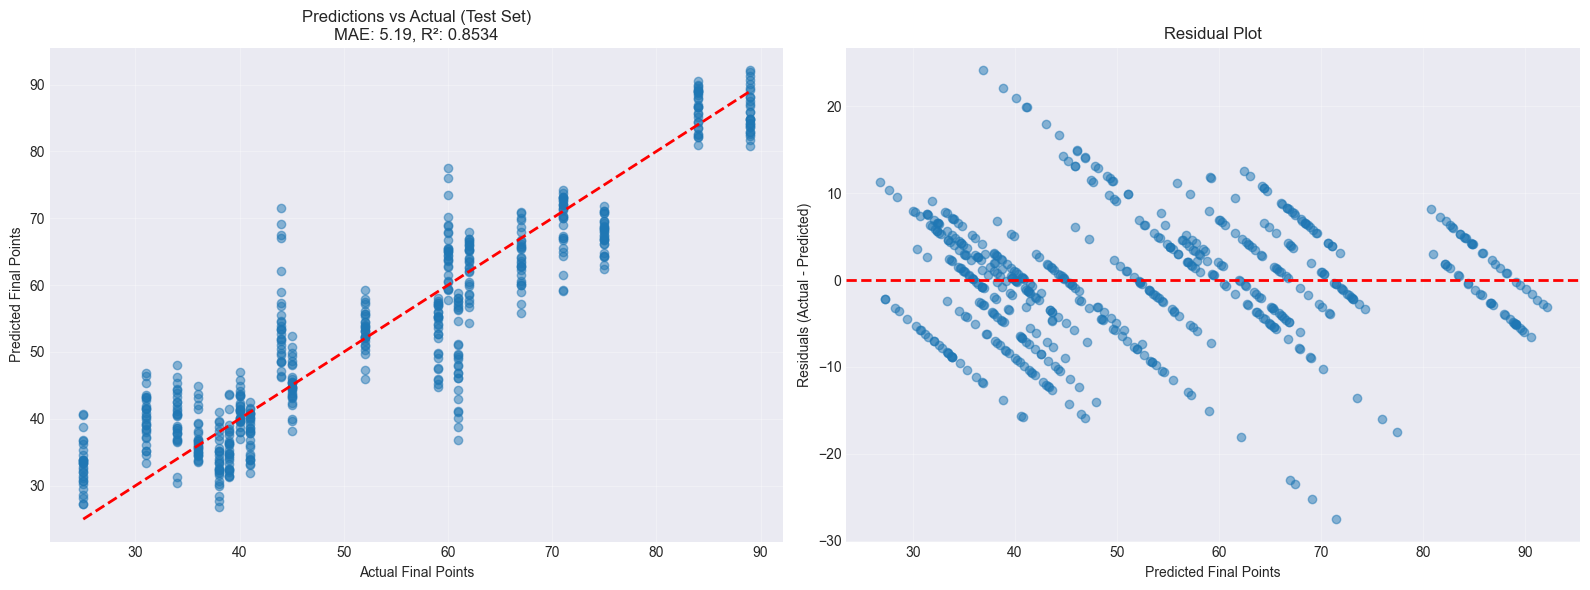

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Final Points')
axes[0].set_ylabel('Predicted Final Points')
axes[0].set_title(f'Predictions vs Actual (Test Set)\nMAE: {test_mae:.2f}, R²: {test_r2:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Final Points')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Cellule 12 — Sauvegarde du modèle

In [31]:
import joblib
from datetime import datetime

# Save model
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = model_dir / f'best_model_{timestamp}.joblib'

joblib.dump(best_model, model_path)

print(f"✅ Best model saved to {model_path}")
print(f"\n📊 Model Info:")
print(f"   Type: {best_model_key}")
print(f"   Test MAE: {test_mae:.2f} points")
print(f"   Test R²: {test_r2:.4f}")


✅ Best model saved to ..\models\best_model_20251211_163244.joblib

📊 Model Info:
   Type: ensemble_stacking
   Test MAE: 5.19 points
   Test R²: 0.8534


Cellule 13 — Résumé final

In [32]:
print("\n" + "="*70)
print("✅ TRAINING PIPELINE COMPLETE!")
print("="*70)
print(f"\n📊 Summary:")
print(f"   Baseline models trained: {len(baseline_results)}")
print(f"   Fine-tuned models: {len(finetuned_results)}")
print(f"   Ensemble models: {len(ensemble_results)}")
print(f"\n🏆 Best Model: {best_model_key}")
print(f"   Test MAE: {test_mae:.2f} points")
print(f"   Test R²: {test_r2:.4f}")
print(f"\n💾 Model saved to: {model_path}")
print(f"\n📊 View all experiments in MLflow UI:")
print(f"   Terminal: mlflow ui --port 5000")
print(f"   Browser: http://localhost:5000")
print("="*70)



✅ TRAINING PIPELINE COMPLETE!

📊 Summary:
   Baseline models trained: 7
   Fine-tuned models: 3
   Ensemble models: 2

🏆 Best Model: ensemble_stacking
   Test MAE: 5.19 points
   Test R²: 0.8534

💾 Model saved to: ..\models\best_model_20251211_163244.joblib

📊 View all experiments in MLflow UI:
   Terminal: mlflow ui --port 5000
   Browser: http://localhost:5000
